In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fasttext/__results__.html
/kaggle/input/fasttext/__notebook__.ipynb
/kaggle/input/fasttext/__output__.json
/kaggle/input/fasttext/custom.css
/kaggle/input/fasttext/finetune/finetune.syn1neg.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_vocab.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_ngrams.npy
/kaggle/input/fasttext/finetune/finetune
/kaggle/input/fasttext/scratch/scratch.wv.vectors_ngrams.npy
/kaggle/input/fasttext/scratch/scratch
/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_t

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import FastText
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from pathlib import Path
import shutil

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Embedding Model Paths
scratch_path = "/kaggle/input/fasttext/scratch/scratch"
pretrained_path = "/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text"
finetuned_path = "/kaggle/input/fasttext/finetune/finetune"

In [3]:
# Loading the embedders
scratch = FastText.load(scratch_path)
pretrained = FastText.load(pretrained_path)
finetuned = FastText.load(finetuned_path)

print(pretrained.wv["ठोक"])

[ 7.61794001e-02 -4.92858231e-01  1.53381422e-01 -2.57078737e-01
  6.35857061e-02  1.04737259e-01  1.69516876e-01  1.93820685e-01
 -1.93721935e-01  1.77664801e-01  2.43365429e-02 -8.30003619e-02
 -2.54510194e-01 -4.06480692e-02 -8.65190253e-02 -6.49958327e-02
  2.22528175e-01  1.52424380e-01  2.54711863e-02  1.91342399e-01
  3.80364150e-01  1.16314612e-01 -1.11801457e-02  1.38561809e-02
 -3.27293165e-02  1.39722675e-01  1.29376486e-01  2.60515630e-01
  2.20912099e-01  1.68706372e-01 -4.08423722e-01 -3.22221816e-02
 -1.31672710e-01  3.94820757e-02  1.16161322e-02 -1.25651777e-01
  2.33733747e-02  8.31987783e-02  2.94195086e-01  1.63125563e-02
  6.76343814e-02 -3.16079706e-01 -1.25883310e-03  3.02024633e-01
 -7.36616179e-02 -2.25306731e-02  1.95028976e-01 -4.23262894e-01
 -1.73440307e-01  3.10934216e-01 -7.87678733e-02  1.86153263e-01
 -7.07686469e-02 -2.87645102e-01 -5.05212322e-02  2.34816104e-01
  1.28308073e-01  5.54363523e-03 -7.95640945e-02 -9.37999934e-02
  1.25269322e-02  2.42083

In [4]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


For fasttext model we cannot enter padsequence zero vector as sub word generation will create non-zero vector which contradicts our implementations on masking

In [5]:
# Using custom dataset to get vectors for our tokens
scratch_train = SequenceDataset(train["sentences"], binary=True, model=scratch, labels=train["labels"])
scratch_test = SequenceDataset(test["sentences"], binary=True, model=scratch, labels=test["labels"])
scratch_val = SequenceDataset(val["sentences"], binary=True, model=scratch, labels=val["labels"])

pretrained_train = SequenceDataset(train["sentences"], binary=True, model=pretrained, labels=train["labels"])
pretrained_test = SequenceDataset(test["sentences"], binary=True, model=pretrained, labels=test["labels"])
pretrained_val = SequenceDataset(val["sentences"], binary=True, model=pretrained, labels=val["labels"])

finetuned_train = SequenceDataset(train["sentences"], binary=True, model=finetuned, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=True, model=finetuned, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=True, model=finetuned, labels=val["labels"])



In [6]:
print(pretrained_val[0])
print(finetuned_test[0][0])

(tensor([[-0.2227, -0.1754, -0.0902,  ...,  0.3893,  0.0946,  0.3693],
        [-0.1171, -0.6463,  0.2926,  ..., -0.0579,  0.2198, -0.0643],
        [-0.0568, -0.2716,  0.0031,  ..., -0.0546,  0.0129,  0.4003],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [7]:
print(scratch_train[0][0].shape)

torch.Size([100, 300])


In [8]:
# Setting up DataLoaders

scratch_train_loader = DataLoader(scratch_train, batch_size=16, shuffle=True)
scratch_test_loader = DataLoader(scratch_test, batch_size=16, shuffle=True)
scratch_val_loader = DataLoader(scratch_val, batch_size=16, shuffle=True)

pretrained_train_loader = DataLoader(pretrained_train, batch_size=16, shuffle=True)
pretrained_test_loader = DataLoader(pretrained_test, batch_size=16, shuffle=True)
pretrained_val_loader = DataLoader(pretrained_val, batch_size=16, shuffle=True)

finetuned_train_loader = DataLoader(finetuned_train, batch_size=16, shuffle=True)
finetuned_test_loader = DataLoader(finetuned_test, batch_size=16, shuffle=True)
finetuned_val_loader = DataLoader(finetuned_val, batch_size=16, shuffle=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model Definition

In [25]:
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * 2, 1) # since BiLSTM
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights

## Training Function

In [26]:
def model_train(model, criterion, optimizer, train_loader, val_loader, save_name, epochs=20):
  # Initialize lists to store training and testing losses
  train_losses = []
  val_losses = []

  # Training and evaluation loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      train_loss = 0
      for X_batch, mask, y_batch in train_loader:
          X_batch = X_batch.to(device)
          mask = mask.to(device)
          y_batch = y_batch.to(device)
          
          optimizer.zero_grad()
          outputs, _ = model(X_batch, mask)
          loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)  # Average loss for training epoch
      train_losses.append(train_loss)

      # Testing phase
      model.eval()
      val_loss = 0
      with torch.no_grad():
          for X_batch, mask, y_batch in val_loader:
              X_batch = X_batch.to(device)
              mask = mask.to(device)
              y_batch = y_batch.to(device)
              
              outputs, _ = model(X_batch, mask)
              loss = criterion(outputs, y_batch.long())
              val_loss += loss.item()
      val_loss /= len(val_loader)  # Average loss for val epoch
      val_losses.append(val_loss)

      # Print losses for the epoch
      print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

  # Plot the learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, epochs+1), val_losses, label='Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curve')
  plt.legend()
  plt.grid()
  plt.savefig(f"/kaggle/working/{save_name}.png", bbox_inches='tight', dpi=300)
  plt.show()


## Training Model on Scratch Dataset

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
# 300 embeddings size with a hidden state output of 128 dim
scratch_model = BiLSTMAttention(input_dim=300, hidden_dim=128, num_classes=6).to(device)
scratch_criterion = nn.CrossEntropyLoss()
scratch_optimizer = torch.optim.AdamW(scratch_model.parameters(), lr=3e-4, weight_decay=0.01)

print(scratch_model)
print(f"Trainable parameters: {count_parameters(scratch_model):,}")

BiLSTMAttention(
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (attn): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
Trainable parameters: 442,631


Epoch 1/20, Train Loss: 1.0114, Val Loss: 0.8533
Epoch 2/20, Train Loss: 0.7677, Val Loss: 0.8159
Epoch 3/20, Train Loss: 0.7129, Val Loss: 0.7745
Epoch 4/20, Train Loss: 0.6741, Val Loss: 0.7661
Epoch 5/20, Train Loss: 0.6658, Val Loss: 0.7549
Epoch 6/20, Train Loss: 0.6290, Val Loss: 0.7326
Epoch 7/20, Train Loss: 0.6078, Val Loss: 0.7373
Epoch 8/20, Train Loss: 0.5897, Val Loss: 0.7499
Epoch 9/20, Train Loss: 0.5688, Val Loss: 0.7754
Epoch 10/20, Train Loss: 0.5500, Val Loss: 0.7567
Epoch 11/20, Train Loss: 0.5399, Val Loss: 0.7576
Epoch 12/20, Train Loss: 0.5171, Val Loss: 0.7230
Epoch 13/20, Train Loss: 0.5021, Val Loss: 0.7400
Epoch 14/20, Train Loss: 0.4871, Val Loss: 0.7709
Epoch 15/20, Train Loss: 0.4652, Val Loss: 0.7680
Epoch 16/20, Train Loss: 0.4650, Val Loss: 0.7977
Epoch 17/20, Train Loss: 0.4403, Val Loss: 0.7704
Epoch 18/20, Train Loss: 0.4256, Val Loss: 0.7929
Epoch 19/20, Train Loss: 0.4035, Val Loss: 0.7907
Epoch 20/20, Train Loss: 0.3971, Val Loss: 0.7728


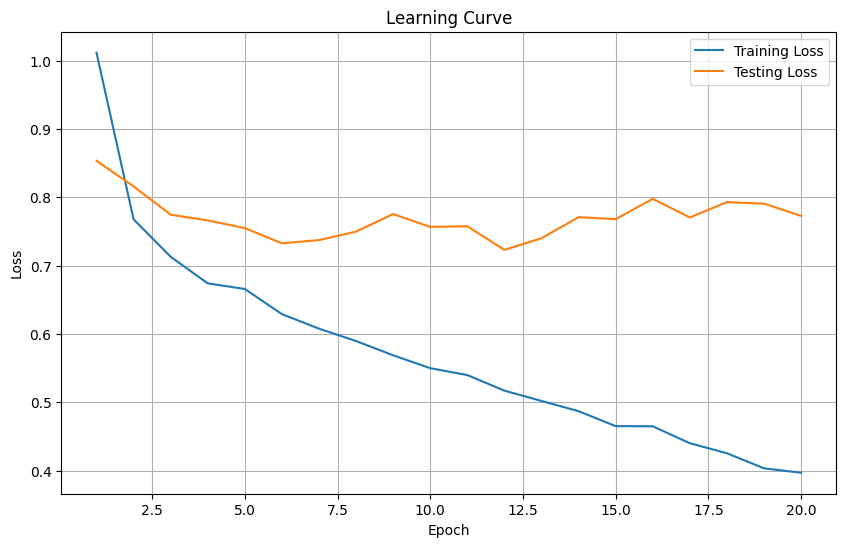

In [28]:
model_train(scratch_model, scratch_criterion, scratch_optimizer, scratch_train_loader, scratch_val_loader, "fasttext_scratch_loss", 20)